# Quantum Kernel Estimator Challenge

## Submission Summary

### Todo 1: (similar to the QVC challenge)
For this first task, we need to implement the embedding for the feature map as presented in Havlíček et al. which is given by:

$$U_{\Phi(\textbf{x})} = \exp\bigg(i \sum_{S \subseteq [n]} \phi_S(\textbf{x}) \prod_{i \in S} Z_i \bigg) \quad \text{(*)}$$

Where: $[n]$ is the powerset of $n$, and $n$ is the number of qubits in our circuit.  In this example $n = 2$ which means:

$$[n] = \{\{0\}, \{1\}, \{0, 0\}\} \qquad \text{we started counting from index 0}$$

and we have chosen: $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

The expression $\text{(*)}$ can be simplified as:

$$\begin{align}
U_{\Phi(\textbf{x})} &= \exp\bigg(i \left(\phi_0(\textbf{x}) Z_0 + \phi_1(\textbf{x}) Z_1 + \phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \right)\bigg) \\
 &= \exp\big(i \phi_0(\textbf{x}) Z_0\big)  \exp\big(i\phi_1(\textbf{x}) Z_1\big) \exp\big(i\phi_{\{0, 1\}}(\textbf{x}) Z_0 \times Z_1 \big) \\
 &= Rz_0\big(\phi_0(\textbf{x})\big) \; Rz_1\big(\phi_1(\textbf{x})\big) \; CNOT_{\{0, 1\}} \; Rz_1\big(\phi_{\{0, 1\}}(\textbf{x})\big) \; CNOT_{\{0, 1\}}
 \end{align}$$

The use the fact that $\exp(i \theta Z) = Rz\big(\theta\big)$, because Pauli matrices $X, Y, Z$ are generators of rotations. The subscript indicates which qubit the gates is executed on.

Now, that we have the expression for $U_{\Phi(\textbf{x})}$, we just need to implement it using pennylane.

Note that we have to repeat the circuit $H^{n} U_{\Phi(\textbf{x})}$ 2 times as presented by Havlíček et al.

### Todo 2: Quantum Kernel Estimation
We implemented 2 strategies to estimate the kernel.
1. The first one is the one presented in the Havlíček et al. paper. It was the advantage of requiring less qubits but at the cost of have a longer circuit. It also showed better results in our tests (by comparing it to the ideal kernel)
2. The second one is the famous [SWAP Test](https://en.wikipedia.org/wiki/Swap_test). It has the advantage having a circuit with less depth but it requires more qubits. It also showed slighly worse results compared to the Havlíček et al. paper.

Having both this method offers the flexibility to adapt to the quantum hardware we have at hand. If we have a quantum computer with a longer decoherence time, better gate fidelity and small number of qubits then we should opt for the Havlíček et al. method. If on the other, we have a quantum computer with more qubits but less decoherence time/gate fidelity then we should opt for the SWAP test method. 

### Todo 3: Training
For the training, we used the `osqp` library through the `qpsolvers` package to deduce the optimal SVM. We also implemented a function which optimize the `bias` automatically. 

### Todo 4: Testing

We tested both the Havlíček et al. method and the SWAP test method and both showed an accuracy of 100%.


In [1]:
!qbraid jobs enable haqs  # enable quantum jobs

You have already enabled qBraid Quantum Jobs in the haqs environment.


In [2]:
TEAM_NAME = "CQTech"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

## Load and visualize dataset

As before, we are given data from a training set $T$ and a test set $S$ of a subset $\Omega \in \rm {I\!R}^n$. Both are assumed to be labelled by the map $m: T \cup S \rightarrow \{+1, −1\}$ unkown to the algorithm. To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

In [4]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [5]:
DATA_PATH = "data/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(
    X_data, Y_data, train_size=1 / n_sets
)

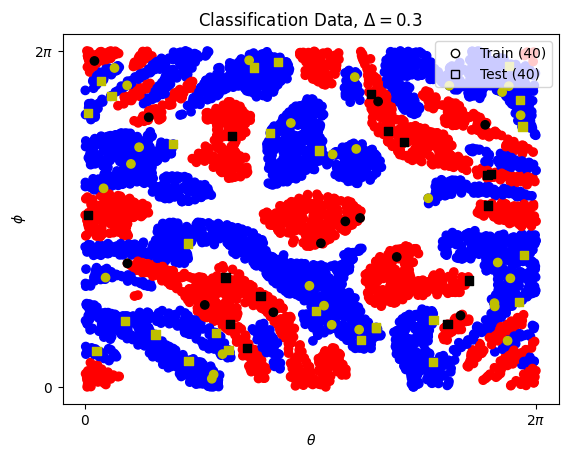

In [6]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

In [7]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [8]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

In [9]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [10]:
def embedding(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    qml.RZ(- 2 * x[0], wires = 0)
    qml.RZ(- 2 * x[1], wires = 1)
    
    qml.CNOT(wires = [0, 1])
    qml.RZ(- 2 * x[2], wires = 1)
    qml.CNOT(wires = [0, 1])

## Quantum kernel (ideal)

In [11]:
dev_kernel = qml.device("default.qubit", wires=n_wires)

projector = np.zeros((2**n_wires, 2**n_wires))
projector[0, 0] = 1


@qml.qnode(dev_kernel)
def kernel(x, z):
    """Compute quantum kernel element for two feature vectors.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(2):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(2):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)

    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [12]:
def kernel_ideal(A, B):
    """Ideal kernel matrix for sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

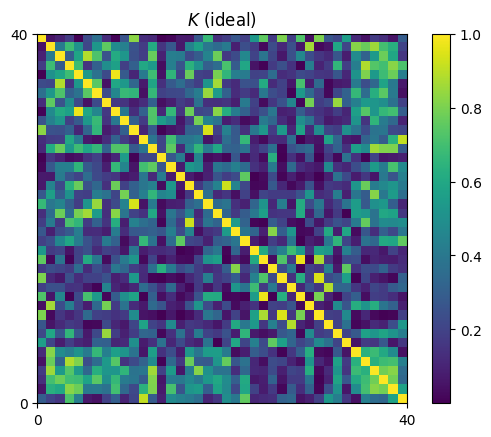

In [13]:
# Visualize ideal kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (right)

k_ideal = kernel_ideal(X_train, X_train)

im = plt.imshow(k_ideal, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$ (ideal)")
plt.show()

## Quantum kernel estimator

The kernel $K_{ij}$ is matrix whose entries are $|\langle \Phi(\textbf{x}_i) | \Phi(\textbf{x}_j)\rangle|^2$. 

We know two quantum methods to estimate that kernel the first one is the method presented in Havlíček et al. in fig 2.c and is implemented as presented below:

###  Havlíček et al.

In [14]:
shots = 500_000 # We have increased the number of shots to get a precise estimate

dev_est = qml.device("default.qubit", wires=n_wires, shots=shots)


@qml.qnode(dev_est)
def fidelity_estimate(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """

    # TODO (hint: Havlicek Fig. 2.c.)    
    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        embedding(x_enc)

    for _ in range(S_size):
        qml.adjoint(embedding)(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)
            
    return qml.probs(wires=range(n_wires))

(<Figure size 2300x300 with 1 Axes>, <Axes: >)

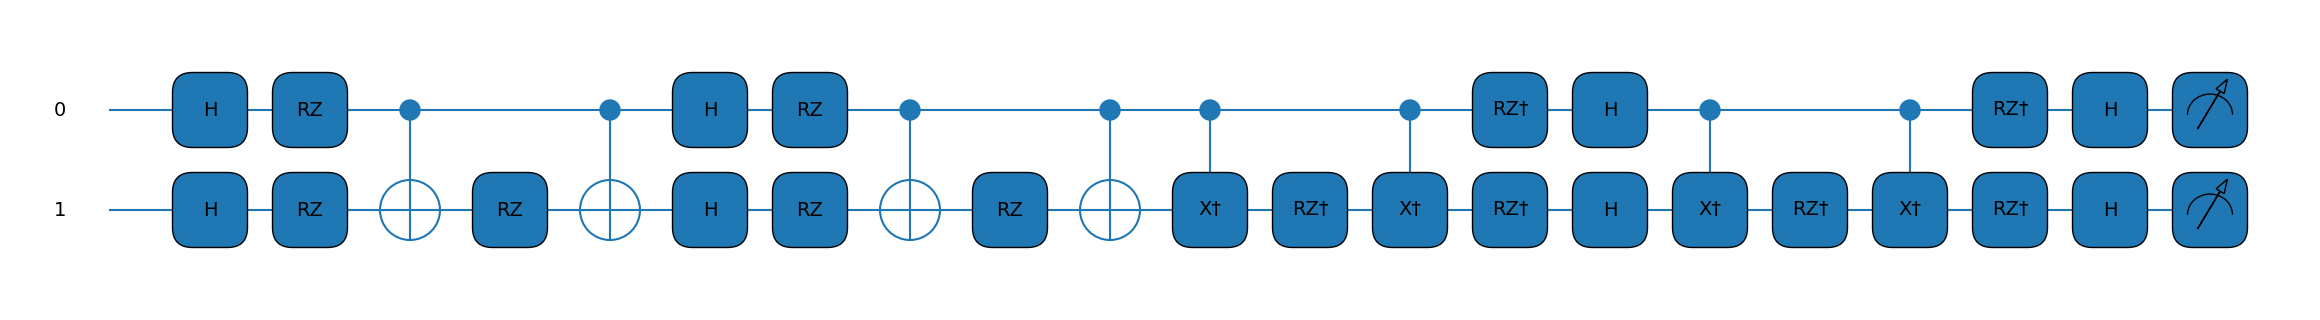

In [15]:
qml.draw_mpl(fidelity_estimate)(X_train[0], X_train[0])

In [16]:
def kernel_experimental_1(A, B):
    """Experimentally estimated kernel matrix for sets A and B."""
    # We compute the fidelity estimate between each entry A and B
    kernel = np.zeros((A.shape[0], A.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            kernel[i, j] = fidelity_estimate(A[i], B[j])[0]
    return kernel

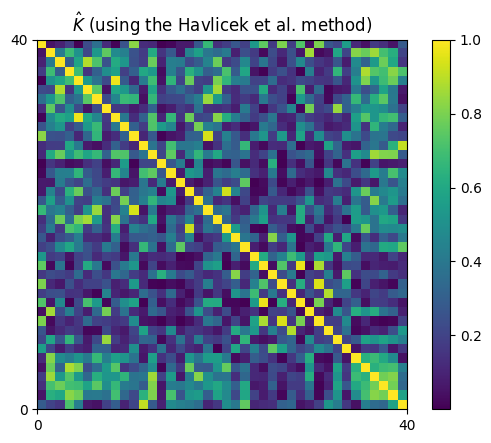

In [17]:
# Visualize experimental kernel matrix containing the inner products of all
# data points used for training, c.f. Havlicek Fig. 4.a (left)

k_exp_1 = kernel_experimental_1(X_train, X_train)

im = plt.imshow(k_exp_1, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (using the Havlicek et al. method)")
plt.show()

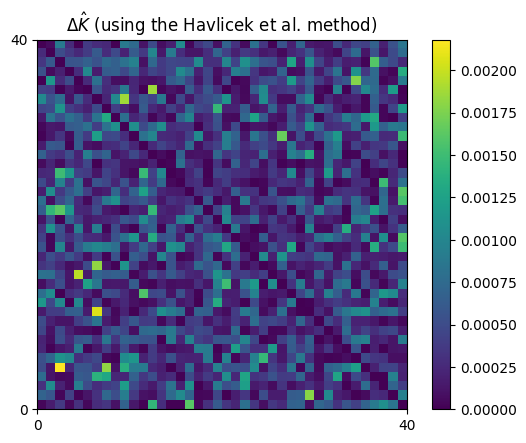

In [18]:
# We can plot the absolute difference between the Ideal kernel and estimated kernel
# We can see that the difference is really small $<0.01$

k_diff_1 = np.abs(k_exp_1 - k_ideal)

im = plt.imshow(k_diff_1, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\Delta\hat{K}$ (using the Havlicek et al. method)")
plt.show()

In [19]:
print("The average absolute difference between the ideal kernel and Havlicek et al. kernel", np.average(k_diff_1))

The average absolute difference between the ideal kernel and Havlicek et al. kernel 0.0004182673517540931


In [20]:
print(f"Circuit depth: {qml.specs(fidelity_estimate)(X_train[0], X_train[0])['depth']}")
print(f"Required qubits: {qml.specs(fidelity_estimate)(X_train[0], X_train[0])['num_used_wires']}")

Circuit depth: 20
Required qubits: 2


### SWAP Test

In [21]:
shots = 500_000

dev_est = qml.device("default.qubit", wires= 2 + 2 + 1, shots=shots)


@qml.qnode(dev_est)
def swap_test(x, z):
    """Directly estimate the fidelity between a pair of feature vectors for data `x` and `z`

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector

    """   
    x_enc = encode_data(x)
    z_enc = encode_data(z)
    for _ in range(S_size):
        # Encoding the x-state
        qml.Hadamard(wires=1)
        qml.Hadamard(wires=2)
        qml.RZ(- 2 * x_enc[0], wires=1)
        qml.RZ(- 2 * x_enc[1], wires=2)

        qml.CNOT(wires = [1, 2])
        qml.RZ(- 2 * x_enc[2], wires=2)
        qml.CNOT(wires = [1, 2])

         # Encoding the z-state
        qml.Hadamard(wires=3)
        qml.Hadamard(wires=4)
        qml.RZ(- 2 * z_enc[0], wires=3)
        qml.RZ(- 2 * z_enc[1], wires=4)

        qml.CNOT(wires = [3, 4])
        qml.RZ(- 2 * z_enc[2], wires=4)
        qml.CNOT(wires = [3, 4])
    
    # Ancilla and swap testing
    qml.Hadamard(wires=0)
    qml.CSWAP(wires=[0, 1, 3])
    qml.CSWAP(wires=[0, 2, 4])
    qml.Hadamard(wires=0)
            
    return qml.probs(wires=0)

(<Figure size 1600x600 with 1 Axes>, <Axes: >)

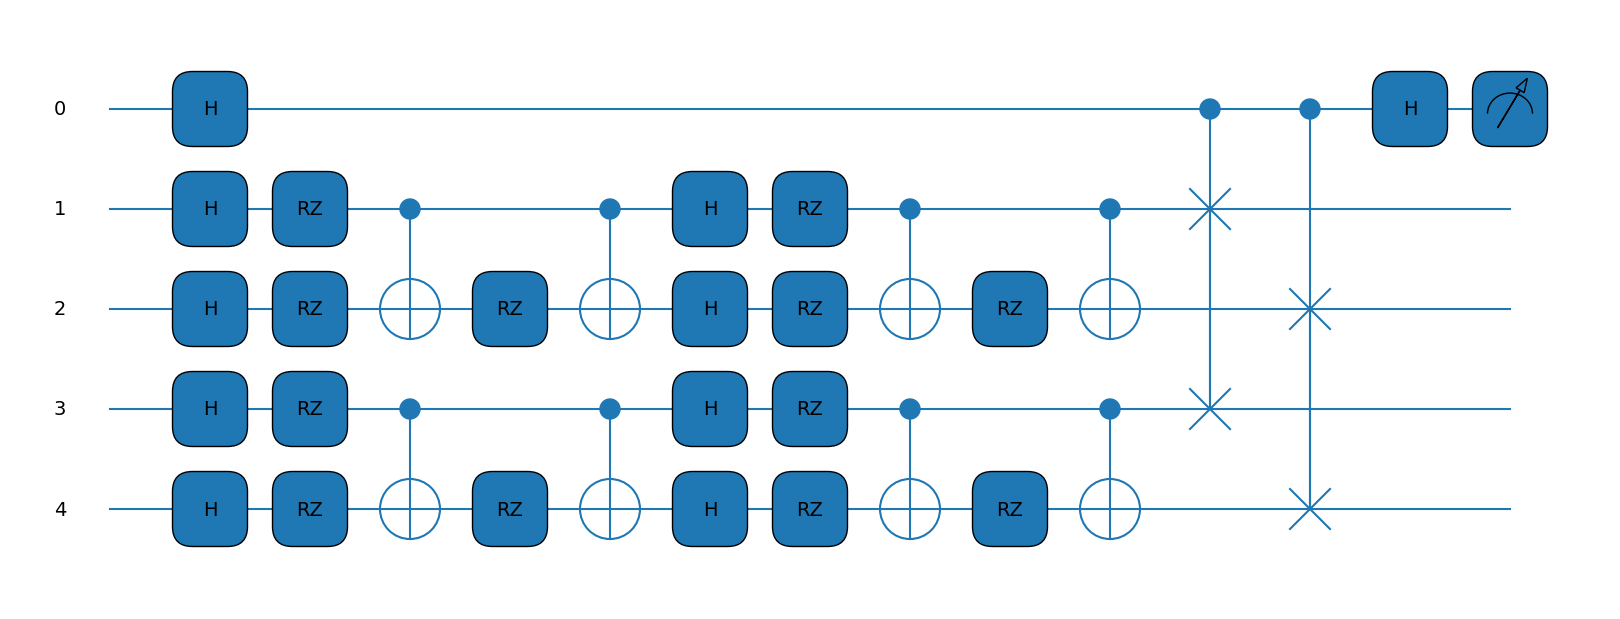

In [22]:
qml.draw_mpl(swap_test)(X_train[0], X_train[0])

In [23]:
def kernel_experimental_2(A, B):
    """Experimentally estimated kernel matrix for sets A and B."""
    kernel = np.zeros((A.shape[0], A.shape[0]))
    for i in range(A.shape[0]):
        for j in range(B.shape[0]):
            kernel[i, j] = 1 - 2 * swap_test(A[i], B[j])[1]
    return kernel

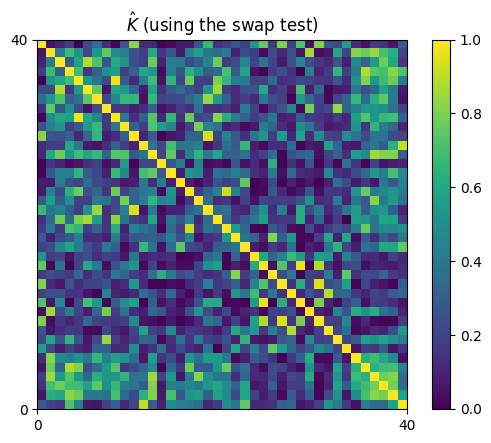

In [24]:
# Visualize experimental kernel matrix containing the inner products of all
# data points used for training using the SWAP Test method

k_exp_2 = kernel_experimental_2(X_train, X_train)

im = plt.imshow(k_exp_2, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\hat{K}$ (using the swap test)")
plt.show()

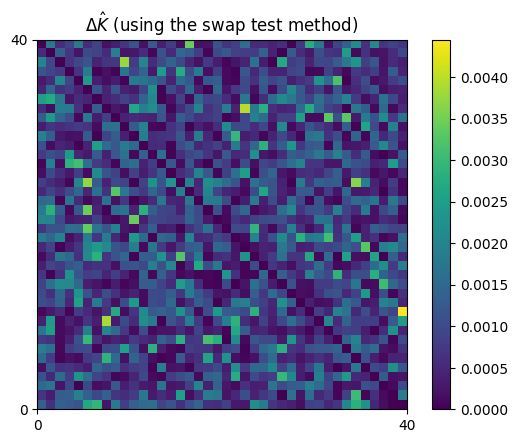

In [25]:
# We can plot the absolute difference between the Ideal kernel and estimated kernel
# We can see that the difference is really small $<0.01$

k_diff_2 = np.abs(k_exp_2 - k_ideal)

im = plt.imshow(k_diff_2, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$\Delta\hat{K}$ (using the swap test method)")
plt.show()

In [26]:
print("The average absolute difference between the ideal kernel and Swap test kernel",np.average(k_diff_2))

The average absolute difference between the ideal kernel and Swap test kernel 0.0009305478062050956


In [27]:
print(f"Circuit depth: {qml.specs(swap_test)(X_train[0], X_train[0])['depth']}")
print(f"Required qubits: {qml.specs(swap_test)(X_train[0], X_train[0])['num_used_wires']}")

Circuit depth: 13
Required qubits: 5


### Summary and Comparaison

We see that both methods offer a pretty good estimate for the Kernel. The SWAP test method offers the advantage of having a small depth but it requires more qubits.
On the other hand the Havlicek et al. has longer depth but needs fewer qubits. 

In this example, the Havlicek et al. slightly outperforms the SWAP test method.

## TODO: Implement training algorithm

In [28]:
# TODO: Implement classification algorithm

We need to have a quadratic problem solver. We will use the `qpsolvers` package which offers a nice interface to use `osqp`.

In [29]:
!pip install qpsolvers[open_source_solvers] --quiet

In [30]:
from qpsolvers import solve_qp

In [31]:
def find_bias(alphas, X_train, Y_train):
    """Returns the bias value using a data set and its corresponding
    Lagrange multipliers.

    Parameters
    ----------
        alphas : ndarray
            Result of the classical optimizer.
        X_train : ndarray
            the training set inputs.
        Y_train : ndarray
            the training set labels.

    Returns
    -------
        float
            the model's bias.

    """
    
    chosen_idx = np.argsort(alphas)[-1].item() # Picking the largest alpha
    if alphas[chosen_idx] < 1e-2:
        print("warning: alphas are rather small")
        
    sum_ = 0
    
    for alpha, x, y in zip(alphas, X_train, Y_train):
        sum_ += y * alpha * fidelity_estimate(x, X_train[chosen_idx])[0].item()
        
    return sum_ - Y_train[chosen_idx]

In [32]:
def train(kernel, X_train, Y_train):
    """Performs a classical optimization using a quantum kernel on
    a labeled data set.

    Parameters
    ----------
        kernel : ndarray
            Quantum Kernel matrix.
        X_train : ndarray
            training set input.
        Y_train : ndarray
            the training set labels.

    Returns
    -------
        model : dict
        the trained model
        
    """
        
    # finding the alphas
    K = np.copy(kernel)
    K = K * (Y_train.reshape(-1, 1) @ Y_train.reshape(1, -1))
    q = -np.ones(Y_train.shape[0])
    G = -np.eye(Y_train.shape[0])
    h = np.zeros(Y_train.shape[0])
    A = Y_train
    b = np.array([0.])
    alphas = solve_qp(K, q, G, h, A, b, solver="osqp")
    
    if alphas is None:
        print("Couldn't solve")
        return None
    
    # finding the bias
    bias = find_bias(alphas, X_train, Y_train).item()
    model = {"alphas": alphas, "bias": bias}
    
    return model


In [33]:
havlicek_model = train(k_exp_1, X_train, Y_train)

In [34]:
swaptest_model = train(k_exp_2, X_train, Y_train)

In [35]:
# TODO: Test accuracy

In [36]:
def predict_havlicek(model, X_train, Y_train, s):
    """Predicts the point s using the Havlicek's model 

    Parameters
    ----------
    model : dict
        the model used to make the predictions
    X_train : ndarray
        the training set input.
    Y_train : ndarray
        the training set labels.
    s : ndarray
        Datum (i.e: datapoint to be fitted).

    Returns
    -------
    float
        the label prediction for the datapoint s
 
    """
    alphas = model["alphas"]
    bias = model["bias"]
    
    sum_ = 0
    for alpha, x, y in zip(alphas, X_train, Y_train):
        sum_ += (y * alpha * fidelity_estimate(x, s)[0].item()) # Using the fidelity_estimate from havlicek
    
    return np.sign(sum_ + bias)

In [37]:
total = 0

for x, y_true in zip(X_test, Y_test):
    y_pred = predict_havlicek(havlicek_model, X_train, Y_train, x)
    total += y_pred == y_true
    
print(f"Accuracy (Havlicek): {round(100 * total.item() / len(X_test), 2)}%")

Accuracy (Havlicek): 100.0%


In [38]:
def predict_swaptest(model, X_train, Y_train, s):
    """Predicts the point s using the SWAPTest model 

    Parameters
    ----------
    model : dict
        the model used to make the predictions
    X_train : ndarray
        the training set input.
    Y_train : ndarray
        the training set labels.
    s : ndarray
        Datum (i.e: datapoint to be fitted).

    Returns
    -------
    float
        the label prediction for the datapoint s
 
    """
    alphas = model["alphas"]
    bias = model["bias"]
    
    sum_ = 0
    for alpha, x, y in zip(alphas, X_train, Y_train):
        sum_ += (y * alpha * swap_test(x, s)[0].item()) # Using the SWAP Test
    
    return np.sign(sum_ + bias)

In [39]:
total = 0

for x, y_true in zip(X_test, Y_test):
    y_pred = predict_swaptest(swaptest_model, X_train, Y_train, x)
    total += y_pred == y_true
    
print(f"Accuracy (SWAP Test): {round(100 * total.item() / len(X_test), 2)}%")

Accuracy (SWAP Test): 100.0%
